### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler

import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV


### Read and preprocess data

In [39]:
EEG_112_CH2 = pd.read_csv('EEG_112_CH2.csv')
bis_112 = pd.read_csv('bis_112.csv')

In [40]:
B112=bis_112['BIS/BIS']
E112=EEG_112_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 112 is {} and {} '.format(E112.shape,B112.shape) )

The shape of EEG signals and BIS for patient 112 is (1374698,) and (10737,) 


In [4]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E112)

Missing Values:
Total Missing Values: 314
Percentage of Missing Values: 0.022841380434102616 %


In [5]:
E112_copy = np.copy(E112)

In [6]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E112_copy)

array([11.65, 11.65, 11.65, ..., 15.5 , 15.5 , 15.5 ])

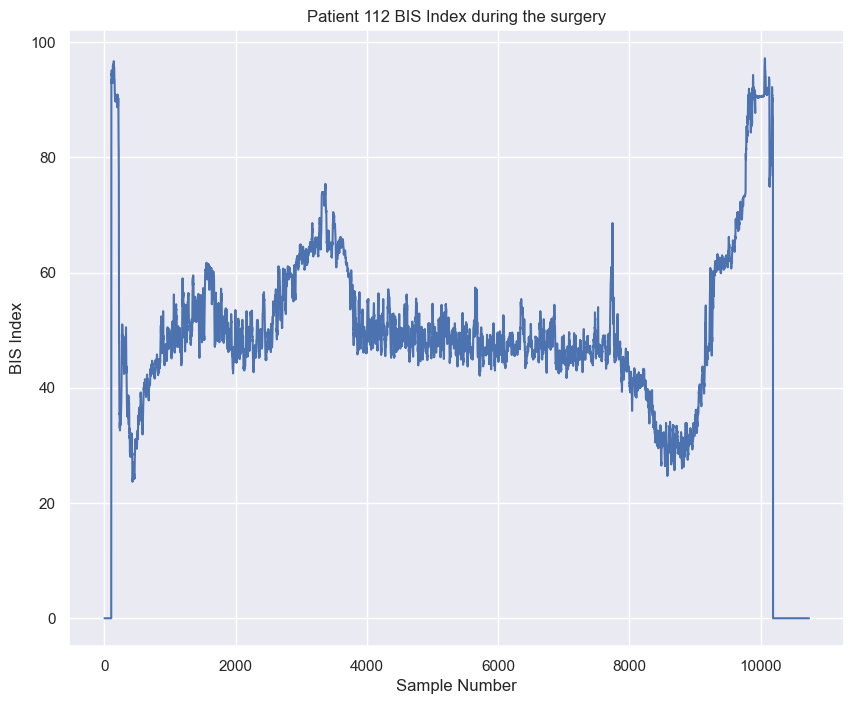

In [42]:
# Patient 112 BIS values throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(B112)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patient 112 BIS Index during the surgery")
plt.show()

In [43]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B112
EEG = E112_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 60
bis_end_index = 10180

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)
print(len(selected_bis))


[  21.4    17.7    24.25 ...  -54.8  -155.15 -106.55]
10120


Number of BIS before windowing: 10120


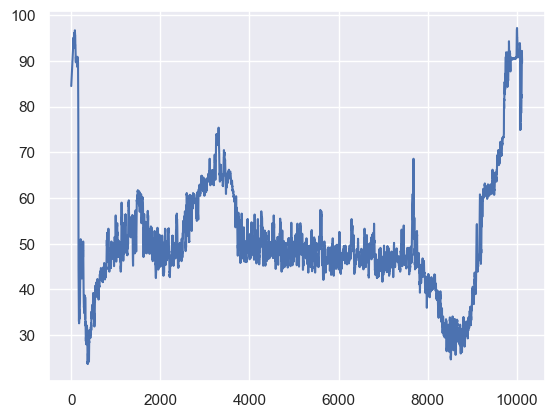

In [45]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = selected_bis
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)
print("Number of BIS before windowing:", len(new_bis))

### Bandpass filtering

In [10]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)


### Variational mode decomposition

In [11]:
import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes

fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Save the modes

In [12]:
np.savetxt("modes0.csv", modes[0], delimiter=",", header="modes0")
np.savetxt("modes1.csv", modes[1], delimiter=",", header="modes1")
np.savetxt("modes2.csv", modes[2], delimiter=",", header="modes2")
np.savetxt("modes3.csv", modes[3], delimiter=",", header="modes3")
np.savetxt("modes4.csv", modes[4], delimiter=",", header="modes4")

In [13]:
mod=pd.read_csv('modes0.csv')
mod.head()

# modes0
0 -2.595382
1 -2.668992
2 -2.703171
3 -2.761378
4 -2.960728

### Feature extraction and windowing

Number of BIS: 10065


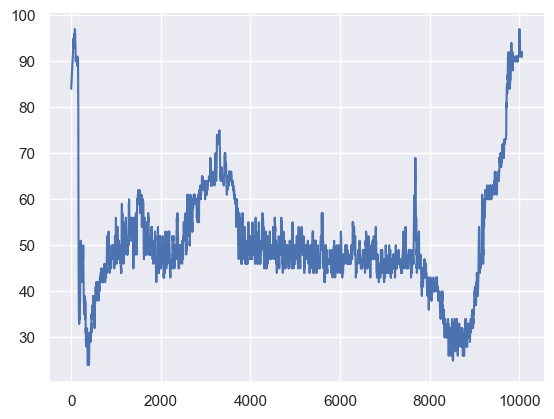

In [50]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = new_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)
bis_windows=np.round(bis_windows)


# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [60]:
#### For entropies

def moving_sliding_window(data, method, window_size_sec=56, overlap_sec=55, sampling_rate=128):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            embedding_dimension = 2
            tolerance = 0.2
            sample_entropy = sampen(window, emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy)
    
            
        if method == "spectral entropy":
            # Calculate sample entropy within the window
            sf=128
            spectral_entropy = ant.spectral_entropy(window, sf)
            result.append(spectral_entropy)
            
            
        if method == "lzc":
            # Calculate sample entropy within the window
            lzc_entropy = ant.lziv_complexity(window)
            result.append(lzc_entropy)
            
        if method == "svd":
            # Calculate sample entropy within the window
            svd_entropy = ant.svd_entropy(window)
            result.append(svd_entropy)
            
        if method == "dispm":
            # Calculate dispersion_entropy_multiscale_refined within the window
            disp_m, prob = sp.dispersion_entropy_multiscale_refined(window,classes=2, emb_dim=3, delay=1,return_all=False)
            result.append(disp_m)

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=2, scale=4, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "fuzzy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window, m=3, r=0.5, Fx='gudermannian')
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
            
            # Higuchi Fractal Dimension
        if method == "hfd":
            hfd = ant.higuchi_fd(window)
            result.append(hfd)
          
            # # Katz Fractal Dimension
        if method == "kfd":
            kfd = ant.katz_fd(window)
            result.append(kfd)
            
    
        
    return result


In [16]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 10065


Number of features: 10065


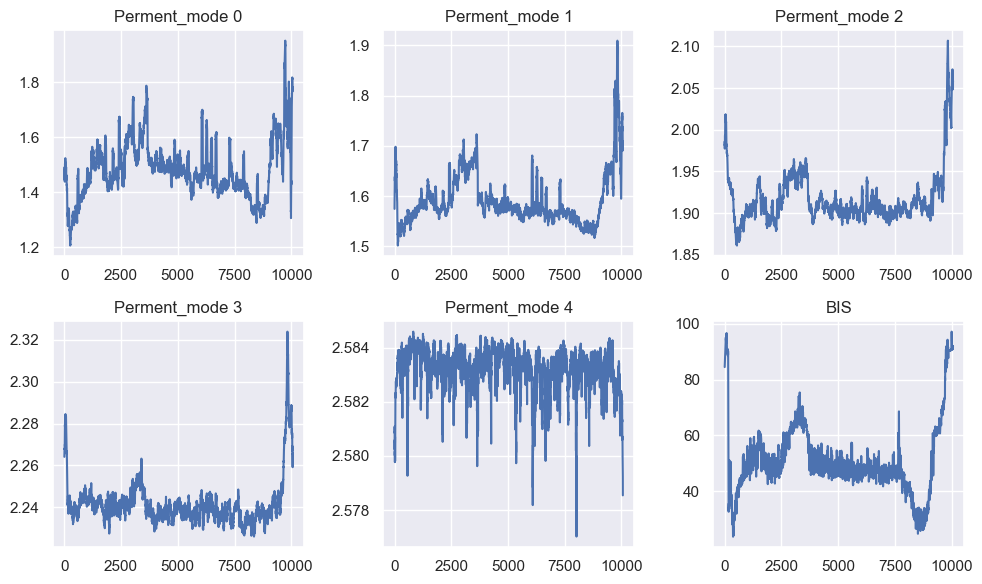

In [17]:
print(f"Number of features:", len(resultsp_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [18]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspet_0 = moving_sliding_window(data0, method='pet')
resultspet_1 = moving_sliding_window(data1, method='pet')
resultspet_2 = moving_sliding_window(data2, method='pet')
resultspet_3 = moving_sliding_window(data3, method='pet')
resultspet_4 = moving_sliding_window(data4, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 10065


In [19]:
print(f"Number of features:", len(resultspet_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspet_0)
axes[0, 0].set_title('pet_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspet_1)
axes[0, 1].set_title('pet_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspet_2)
axes[0, 2].set_title('pet_mode 2')

axes[1, 0].plot(resultspet_3)
axes[1, 0].set_title('pet_mode 3')

axes[1, 1].plot(resultspet_4)
axes[1, 1].set_title('pet_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 10065


In [20]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshc_0 = moving_sliding_window(data0, method='hc')
resultshc_1 = moving_sliding_window(data1, method='hc')
resultshc_2 = moving_sliding_window(data2, method='hc')
resultshc_3 = moving_sliding_window(data3, method='hc')
resultshc_4 = moving_sliding_window(data4, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 10065


In [21]:
print(f"Number of features:", len(resultshc_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshc_0)
axes[0, 0].set_title('hc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshc_1)
axes[0, 1].set_title('hc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshc_2)
axes[0, 2].set_title('hc_mode 2')

axes[1, 0].plot(resultshc_3)
axes[1, 0].set_title('hc_mode 3')

axes[1, 1].plot(resultshc_4)
axes[1, 1].set_title('hc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 10065


In [22]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshm_0 = moving_sliding_window(data0,  method='hm')
resultshm_1 = moving_sliding_window(data1, method='hm')
resultshm_2 = moving_sliding_window(data2, method='hm')
resultshm_3 = moving_sliding_window(data3, method='hm')
resultshm_4 = moving_sliding_window(data4, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 10065


Number of features: 10065


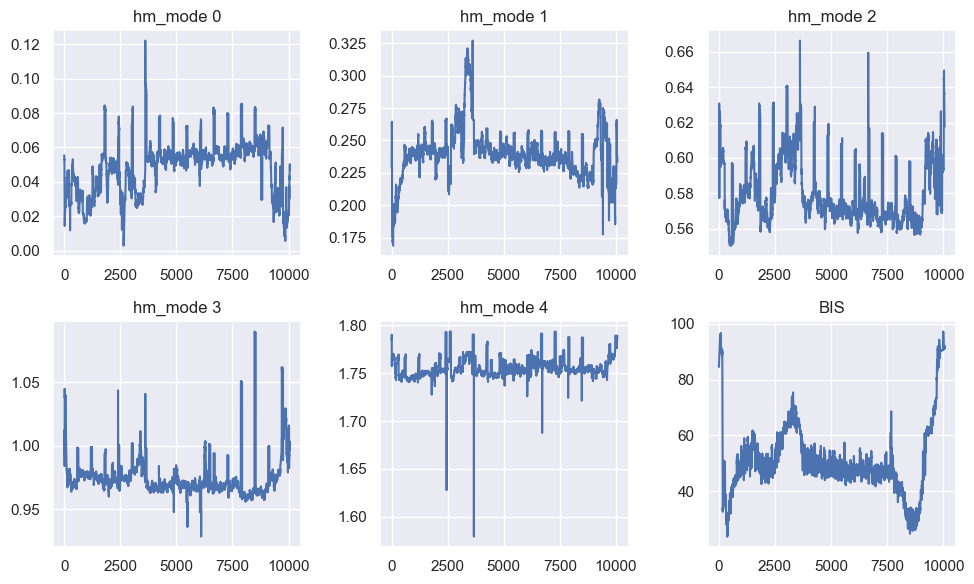

In [23]:
print(f"Number of features:", len(resultshm_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshm_0)
axes[0, 0].set_title('hm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshm_1)
axes[0, 1].set_title('hm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshm_2)
axes[0, 2].set_title('hm_mode 2')

axes[1, 0].plot(resultshm_3)
axes[1, 0].set_title('hm_mode 3')

axes[1, 1].plot(resultshm_4)
axes[1, 1].set_title('hm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [61]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspec_0 = moving_sliding_window(data0, method='spectral entropy')
resultspec_1 = moving_sliding_window(data1, method='spectral entropy')
resultspec_2 = moving_sliding_window(data2, method='spectral entropy')
resultspec_3 = moving_sliding_window(data3, method='spectral entropy')
resultspec_4 = moving_sliding_window(data4, method='spectral entropy')
print(f"Number of features:", len(resultspec_1))

Number of features: 10065


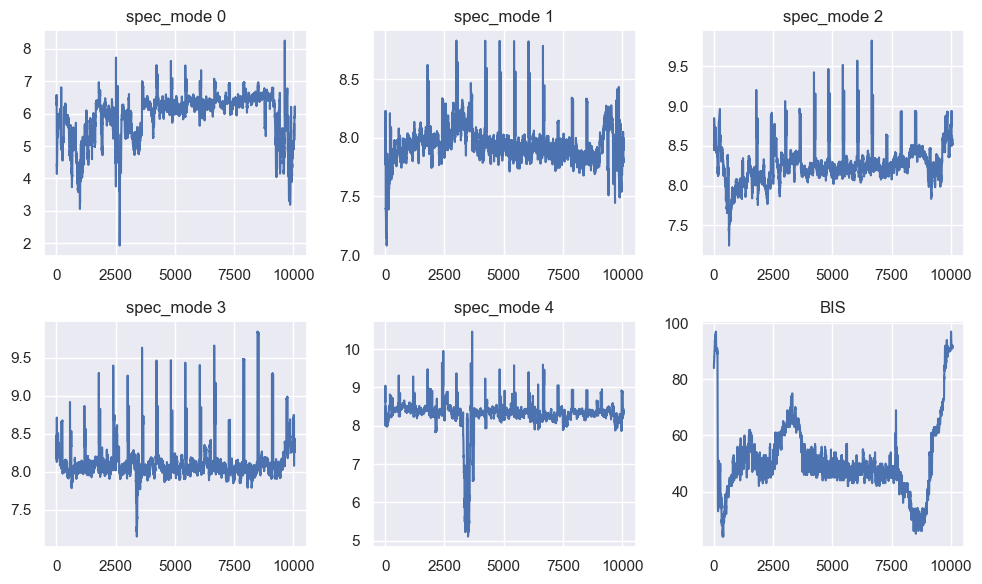

In [62]:
# spectral entropy


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspec_0)
axes[0, 0].set_title('spec_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspec_1)
axes[0, 1].set_title('spec_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspec_2)
axes[0, 2].set_title('spec_mode 2')

axes[1, 0].plot(resultspec_3)
axes[1, 0].set_title('spec_mode 3')

axes[1, 1].plot(resultspec_4)
axes[1, 1].set_title('spec_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [68]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsvd_0 = moving_sliding_window(data0, method='svd')
resultsvd_1 = moving_sliding_window(data1, method='svd')
resultsvd_2 = moving_sliding_window(data2, method='svd')
resultsvd_3 = moving_sliding_window(data3, method='svd')
resultsvd_4 = moving_sliding_window(data4, method='svd')
print(f"Number of features:", len(resultsvd_1))

Number of features: 10065


In [69]:
# svd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsvd_0)
axes[0, 0].set_title('svd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsvd_1)
axes[0, 1].set_title('svd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsvd_2)
axes[0, 2].set_title('svd_mode 2')

axes[1, 0].plot(resultsvd_3)
axes[1, 0].set_title('svd_mode 3')

axes[1, 1].plot(resultsvd_4)
axes[1, 1].set_title('svd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [70]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultshfd_0 = moving_sliding_window(data0, method='hfd')
resultshfd_1 = moving_sliding_window(data1, method='hfd')
resultshfd_2 = moving_sliding_window(data2, method='hfd')
resultshfd_3 = moving_sliding_window(data3, method='hfd')
resultshfd_4 = moving_sliding_window(data4, method='hfd')
print(f"Number of features:", len(resultshfd_0))

Number of features: 10065


In [71]:
# hfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshfd_0)
axes[0, 0].set_title('hfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshfd_1)
axes[0, 1].set_title('hfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshfd_2)
axes[0, 2].set_title('hfd_mode 2')

axes[1, 0].plot(resultshfd_3)
axes[1, 0].set_title('hfd_mode 3')

axes[1, 1].plot(resultshfd_4)
axes[1, 1].set_title('hfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [72]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspec_0 = moving_sliding_window(data0, method='spectral entropy')
resultspec_1 = moving_sliding_window(data1, method='spectral entropy')
resultspec_2 = moving_sliding_window(data2, method='spectral entropy')
resultspec_3 = moving_sliding_window(data3, method='spectral entropy')
resultspec_4 = moving_sliding_window(data4, method='spectral entropy')
print(f"Number of features:", len(resultspec_1))

Number of features: 10065


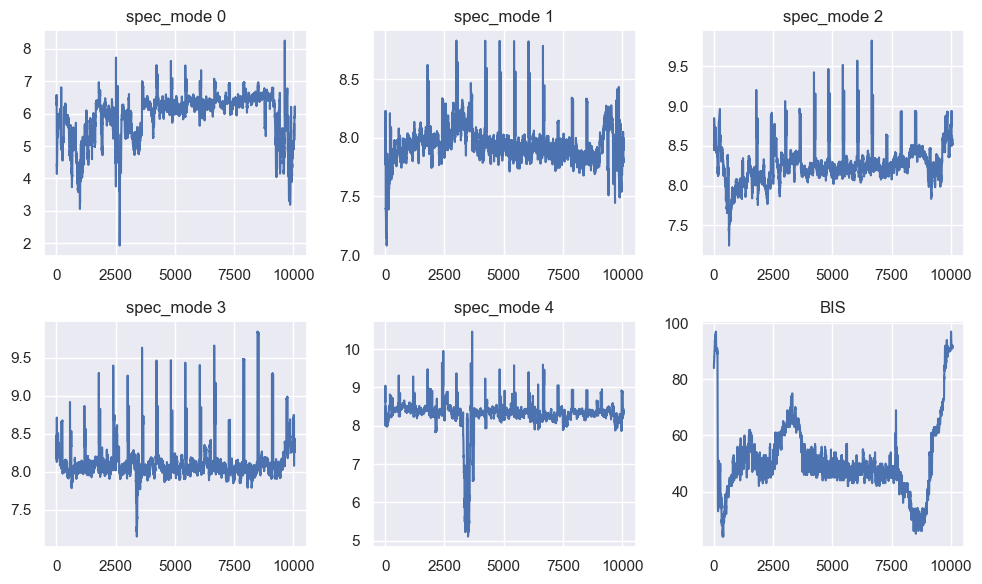

In [73]:
# spectral entropy


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspec_0)
axes[0, 0].set_title('spec_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspec_1)
axes[0, 1].set_title('spec_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspec_2)
axes[0, 2].set_title('spec_mode 2')

axes[1, 0].plot(resultspec_3)
axes[1, 0].set_title('spec_mode 3')

axes[1, 1].plot(resultspec_4)
axes[1, 1].set_title('spec_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [63]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultslzc_0 = moving_sliding_window(data0, method='lzc')
resultslzc_1 = moving_sliding_window(data1, method='lzc')
resultslzc_2 = moving_sliding_window(data2, method='lzc')
resultslzc_3 = moving_sliding_window(data3, method='lzc')
resultslzc_4 = moving_sliding_window(data4, method='lzc')
print(f"Number of features:", len(resultslzc_1))

Number of features: 10065


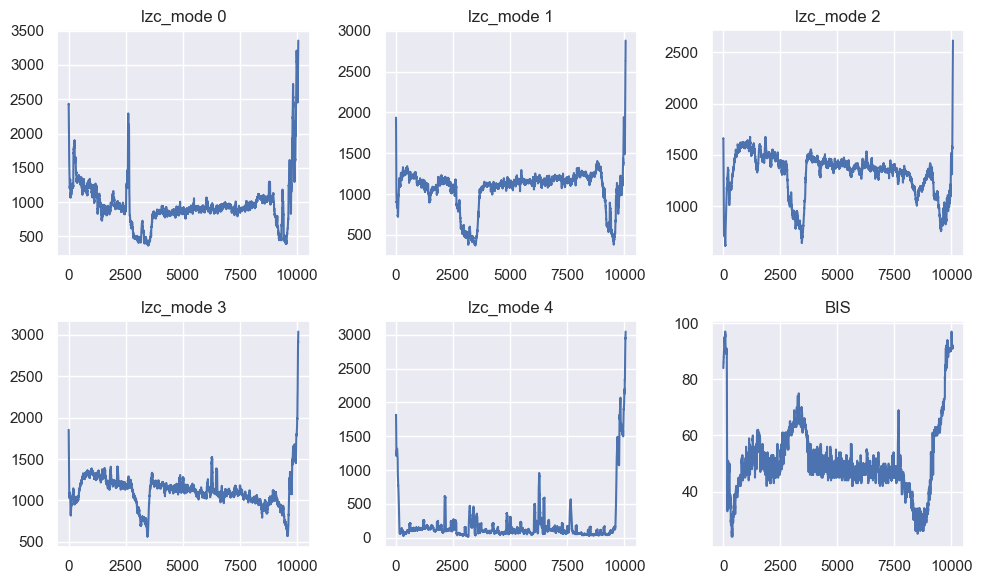

In [64]:
# Lzc


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultslzc_0)
axes[0, 0].set_title('lzc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultslzc_1)
axes[0, 1].set_title('lzc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultslzc_2)
axes[0, 2].set_title('lzc_mode 2')

axes[1, 0].plot(resultslzc_3)
axes[1, 0].set_title('lzc_mode 3')

axes[1, 1].plot(resultslzc_4)
axes[1, 1].set_title('lzc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()

ant.higuchi_fd

# Display the figure
plt.show()

In [26]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdispm_0 = moving_sliding_window(data0, method='dispm')
resultsdispm_1 = moving_sliding_window(data1, method='dispm')
resultsdispm_2 = moving_sliding_window(data2, method='dispm')
resultsdispm_3 = moving_sliding_window(data3, method='dispm')
resultsdispm_4 = moving_sliding_window(data4, method='dispm')
print(f"Number of features:", len(resultsdispm_1))

KeyboardInterrupt: 

In [ ]:
# dispm


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdispm_0)
axes[0, 0].set_title('dispm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdispm_1)
axes[0, 1].set_title('dispm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdispm_2)
axes[0, 2].set_title('dispm_mode 2')

axes[1, 0].plot(resultsdispm_3)
axes[1, 0].set_title('dispm_mode 3')

axes[1, 1].plot(resultsdispm_4)
axes[1, 1].set_title('dispm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [24]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 10065


In [25]:
print(f"Number of features:", len(resultsd_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 10065


### Create Dataframe for each feature

In [ ]:
# dispm

df_dispm = pd.DataFrame({'dispm_mode0': resultsdispm_0, 'dispm_mode1': resultsdispm_1, 'dispm_mode2': resultsdispm_2, 'dispm_mode3': resultsdispm_3, 'dispm_mode4': resultsdispm_4})

df_dispm['BIS']=bis_windows
df_dispm

In [51]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
df_pet



pet_mode0  pet_mode1  pet_mode2  pet_mode3  pet_mode4   BIS
0       1.003208   1.004506   1.009610   1.014567   1.028621  84.0
1       1.003300   1.004579   1.009616   1.014601   1.028616  85.0
2       1.003343   1.004634   1.009639   1.014584   1.028626  85.0
3       1.003325   1.004750   1.009680   1.014590   1.028626  85.0
4       1.003472   1.004804   1.009551   1.014595   1.028605  85.0
...          ...        ...        ...        ...        ...   ...
10060   1.006810   1.005901   1.010736   1.014498   1.028839  92.0
10061   1.006840   1.005853   1.010672   1.014481   1.028839  92.0
10062   1.006804   1.005786   1.010648   1.014453   1.028891  92.0
10063   1.006888   1.005998   1.010818   1.014595   1.028969  92.0
10064   1.006792   1.005925   1.010794   1.014584   1.028974  92.0

[10065 rows x 6 columns]

In [27]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [52]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
df_hc


hc_mode0  hc_mode1  hc_mode2  hc_mode3  hc_mode4   BIS
0      5.651188  1.426556  1.086165  1.021316  1.002157  84.0
1      5.651430  1.426552  1.086168  1.021316  1.002156  85.0
2      5.796054  1.424585  1.084083  1.021760  1.002120  85.0
3      5.888996  1.425323  1.083949  1.021906  1.002083  85.0
4      5.944693  1.422864  1.083330  1.021939  1.002065  85.0
...         ...       ...       ...       ...       ...   ...
10060  6.736489  1.340060  1.083193  1.023933  1.001791  92.0
10061  6.798169  1.340668  1.082977  1.023937  1.001792  92.0
10062  6.880671  1.340683  1.082974  1.023927  1.001792  92.0
10063  6.986512  1.340742  1.082971  1.023924  1.001792  92.0
10064  7.186213  1.341721  1.083147  1.024012  1.001794  92.0

[10065 rows x 6 columns]

In [28]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [29]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

In [74]:
# hfd

df_hfd = pd.DataFrame({'hfd_mode0': resultshfd_0, 'hfd_mode1': resultshfd_1, 'hfd_mode2': resultshfd_2, 'hfd_mode3': resultshfd_3, 'hfd_mode4': resultshfd_4})

df_hfd['BIS']=bis_windows
df_hfd

hfd_mode0  hfd_mode1  hfd_mode2  hfd_mode3  hfd_mode4   BIS
0       1.033162   1.121655   1.731571   1.940963   2.004123  84.0
1       1.033232   1.121734   1.731510   1.941007   2.004103  85.0
2       1.035834   1.122621   1.730878   1.941434   2.004753  85.0
3       1.035293   1.122985   1.731818   1.942750   2.005685  85.0
4       1.037148   1.128566   1.729963   1.943602   2.006323  85.0
...          ...        ...        ...        ...        ...   ...
10060   1.039582   1.121210   1.755111   1.943775   1.998559  92.0
10061   1.038489   1.120405   1.750620   1.942665   1.998388  92.0
10062   1.038636   1.120672   1.750258   1.942860   1.998576  92.0
10063   1.038665   1.120582   1.750071   1.942511   1.998567  92.0
10064   1.039967   1.121355   1.749837   1.942654   1.998755  92.0

[10065 rows x 6 columns]

In [75]:
# dispm

df_dispm = pd.DataFrame({'dispm_mode0': resultsdispm_0, 'dispm_mode1': resultsdispm_1, 'dispm_mode2': resultsdispm_2, 'dispm_mode3': resultsdispm_3, 'dispm_mode4': resultsdispm_4})

df_dispm['BIS']=bis_windows
df_dispm

NameError: name 'resultsdispm_0' is not defined

In [76]:
# spectral entropy

df_spec = pd.DataFrame({'spec_mode0': resultspec_0, 'spec_mode1': resultspec_1, 'spec_mode2': resultspec_2, 'spec_mode3': resultspec_3, 'spec_mode4': resultspec_4})

df_spec['BIS']=bis_windows
df_spec

spec_mode0  spec_mode1  spec_mode2  spec_mode3  spec_mode4   BIS
0        6.436764    7.811588    8.517853    8.256952    8.653618  84.0
1        6.438455    7.813892    8.518327    8.258326    8.653099  85.0
2        6.444699    7.773448    8.506681    8.291561    8.640629  85.0
3        6.435316    7.802861    8.509896    8.268585    8.634790  85.0
4        6.509709    7.923044    8.512643    8.253447    8.631603  85.0
...           ...         ...         ...         ...         ...   ...
10060    6.178710    7.792421    8.511270    8.262952    8.386711  92.0
10061    6.123019    7.791024    8.522849    8.267369    8.382402  92.0
10062    6.091351    7.792274    8.521313    8.265997    8.381954  92.0
10063    6.035085    7.792944    8.521877    8.266743    8.381030  92.0
10064    5.929797    7.802336    8.524720    8.265469    8.381662  92.0

[10065 rows x 6 columns]

In [77]:
# svd

df_svd = pd.DataFrame({'svd_mode0': resultsvd_0, 'svd_mode1': resultsvd_1, 'svd_mode2': resultsvd_2, 'svd_mode3': resultsvd_3, 'svd_mode4': resultsvd_4})

df_svd['BIS']=bis_windows
df_svd

svd_mode0  svd_mode1  svd_mode2  svd_mode3  svd_mode4   BIS
0       0.290651   0.710027   1.093821   1.222051   1.213792  84.0
1       0.290639   0.710031   1.093820   1.222051   1.213791  85.0
2       0.287482   0.710287   1.091280   1.224438   1.212373  85.0
3       0.287398   0.712639   1.091199   1.225069   1.212391  85.0
4       0.287383   0.717374   1.090994   1.225009   1.212529  85.0
...          ...        ...        ...        ...        ...   ...
10060   0.268854   0.717570   1.103396   1.233182   1.200051  92.0
10061   0.267652   0.717568   1.103260   1.232865   1.200111  92.0
10062   0.265828   0.717586   1.103228   1.232830   1.200128  92.0
10063   0.263450   0.717594   1.103232   1.232825   1.200141  92.0
10064   0.259216   0.717843   1.103196   1.233129   1.200273  92.0

[10065 rows x 6 columns]

In [78]:
# lzc

df_lzc = pd.DataFrame({'lzc_mode0': resultslzc_0, 'lzc_mode1': resultslzc_1, 'lzc_mode2': resultslzc_2, 'lzc_mode3': resultslzc_3, 'lzc_mode4': resultslzc_4})

df_lzc['BIS']=bis_windows
df_lzc

lzc_mode0  lzc_mode1  lzc_mode2  lzc_mode3  lzc_mode4   BIS
0           2424       1936       1660       1853       1797  84.0
1           2434       1916       1662       1847       1816  85.0
2           2389       1860       1620       1809       1782  85.0
3           2341       1804       1569       1765       1763  85.0
4           2311       1778       1552       1745       1746  85.0
...          ...        ...        ...        ...        ...   ...
10060       3202       2740       2481       2986       3022  92.0
10061       3236       2780       2522       3015       3025  92.0
10062       3270       2821       2560       3030       3028  92.0
10063       3288       2836       2574       3024       3021  92.0
10064       3355       2880       2613       3040       3046  92.0

[10065 rows x 6 columns]

### Save the extracted data in csv

In [80]:
df_hm.to_csv('hm_112.csv', index=False)
df_hc.to_csv('hc_112.csv', index=False)
df_perm.to_csv('perm_112.csv', index=False)
df_pet.to_csv('pet_112.csv', index=False)
df_disp.to_csv('disp_112.csv', index=False)
#df_dispm.to_csv('dispm_112.csv', index=False)

In [81]:
df_lzc.to_csv('lzc_112.csv' , index=False)
df_hfd.to_csv('hfd_112.csv', index=False)
df_spec.to_csv('spec_112.csv', index=False)
df_svd.to_csv('svd_112.csv', index=False)


In [56]:
pd.read_csv('pet_112.csv')

pet_mode0  pet_mode1  pet_mode2  pet_mode3  pet_mode4   BIS
0       1.003208   1.004506   1.009610   1.014567   1.028621  84.0
1       1.003300   1.004579   1.009616   1.014601   1.028616  85.0
2       1.003343   1.004634   1.009639   1.014584   1.028626  85.0
3       1.003325   1.004750   1.009680   1.014590   1.028626  85.0
4       1.003472   1.004804   1.009551   1.014595   1.028605  85.0
...          ...        ...        ...        ...        ...   ...
10060   1.006810   1.005901   1.010736   1.014498   1.028839  92.0
10061   1.006840   1.005853   1.010672   1.014481   1.028839  92.0
10062   1.006804   1.005786   1.010648   1.014453   1.028891  92.0
10063   1.006888   1.005998   1.010818   1.014595   1.028969  92.0
10064   1.006792   1.005925   1.010794   1.014584   1.028974  92.0

[10065 rows x 6 columns]

In [58]:
df_perm.corr()

Perment_mode0  Perment_mode1  Perment_mode2  Perment_mode3  \
Perment_mode0       1.000000       0.850763       0.564702       0.427362   
Perment_mode1       0.850763       1.000000       0.811957       0.732838   
Perment_mode2       0.564702       0.811957       1.000000       0.825008   
Perment_mode3       0.427362       0.732838       0.825008       1.000000   
Perment_mode4      -0.169204      -0.230487      -0.309672      -0.238606   

               Perment_mode4  
Perment_mode0      -0.169204  
Perment_mode1      -0.230487  
Perment_mode2      -0.309672  
Perment_mode3      -0.238606  
Perment_mode4       1.000000

In [65]:
data_112=pd.DataFrame({'Perment_mode4': resultsp_4,'Pet_mode3': resultspet_3, 'disp_mode4': resultsd_4, 
                  'lzc_mode2':resultslzc_2, 'spec_mode2':resultspec_2, 'hc_mode2':resultshc_2, 'hm_mode2':resultshm_2})
data_112['BIS']=bis_windows
data_112

Perment_mode4  Pet_mode3  disp_mode4  lzc_mode2  spec_mode2  hc_mode2  \
0           2.580879   1.014567    1.735575       1660    8.517853  1.086165   
1           2.580996   1.014601    1.735504       1662    8.518327  1.086168   
2           2.580844   1.014584    1.738717       1620    8.506681  1.084083   
3           2.580874   1.014590    1.744474       1569    8.509896  1.083949   
4           2.581080   1.014595    1.738160       1552    8.512643  1.083330   
...              ...        ...         ...        ...         ...       ...   
10060       2.579638   1.014498    1.709512       2481    8.511270  1.083193   
10061       2.579599   1.014481    1.715073       2522    8.522849  1.082977   
10062       2.579237   1.014453    1.716514       2560    8.521313  1.082974   
10063       2.578603   1.014595    1.727131       2574    8.521877  1.082971   
10064       2.578542   1.014584    1.723201       2613    8.524720  1.083147   

       hm_mode2   BIS  
0      0.602878  84.0  
1      0.602876  85.0  
2      0.601465  85.0  
3      0.601553  85.0  
4      0.601020  85.0  
...         ...   ...  
10060  0.617963  92.0  
10061  0.617823  92.0  
10062  0.617792  92.0  
10063  0.617800  92.0  
10064  0.617587  92.0  

[10065 rows x 8 columns]

In [66]:
data_112.to_csv('data_112.csv', index=False)

In [82]:
data_112=pd.read_csv('data_112.csv')
plt.figure(figsize=(10,6))
sns.heatmap(data_112.corr(), annot = True)
plt.title('Correlation of spec features')
plt.show()

In [83]:
metrics = {}
def plot_regression(data, column):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    
    # Predictions
    y_predicted = reg.predict(X_test)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    
    # Plot the graph#
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="data", c="blue")
    plt.plot(X_test, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

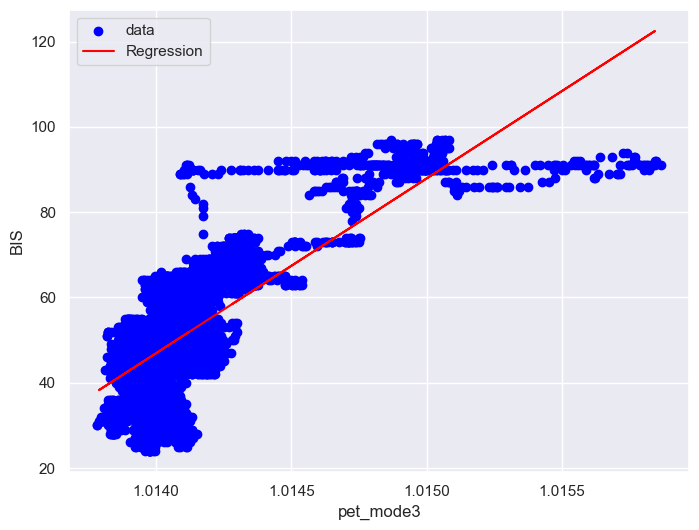

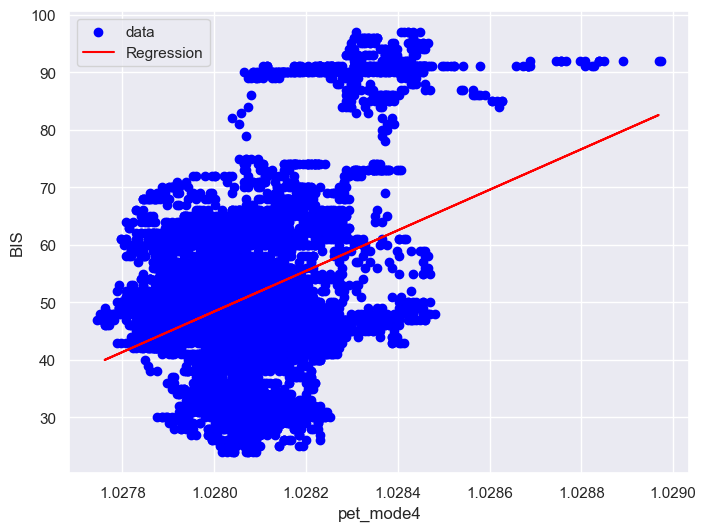

In [85]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

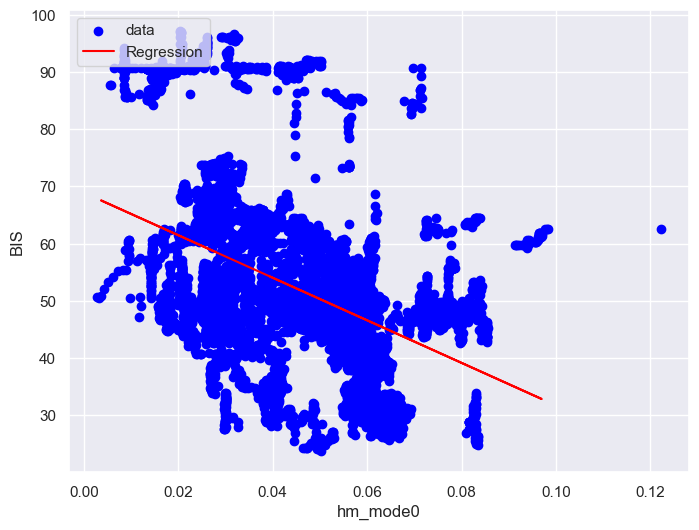

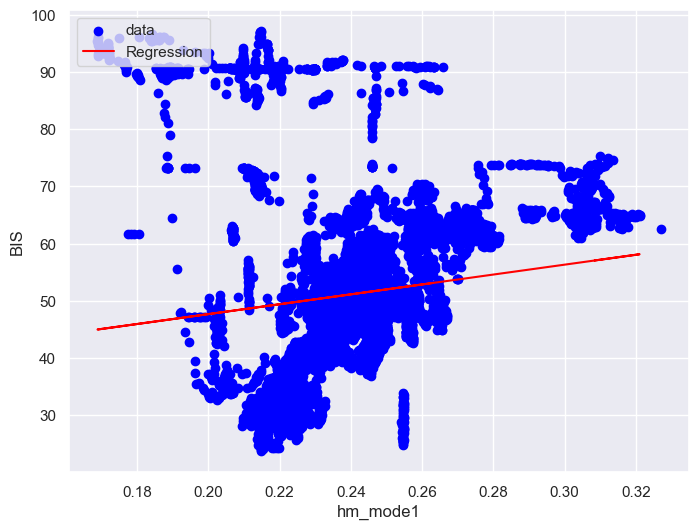

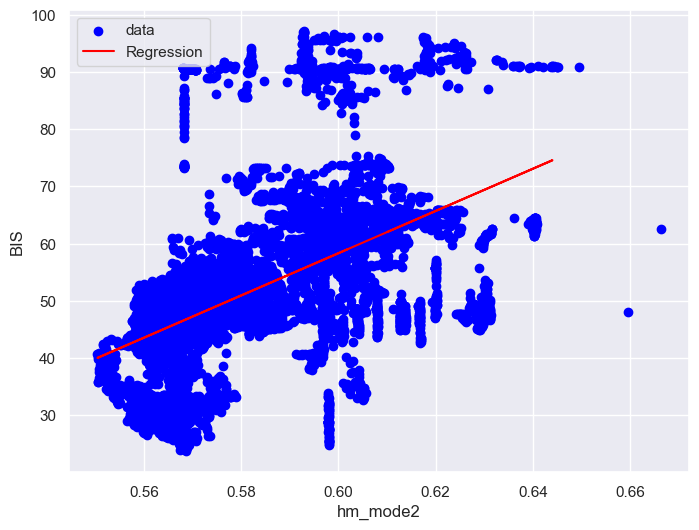

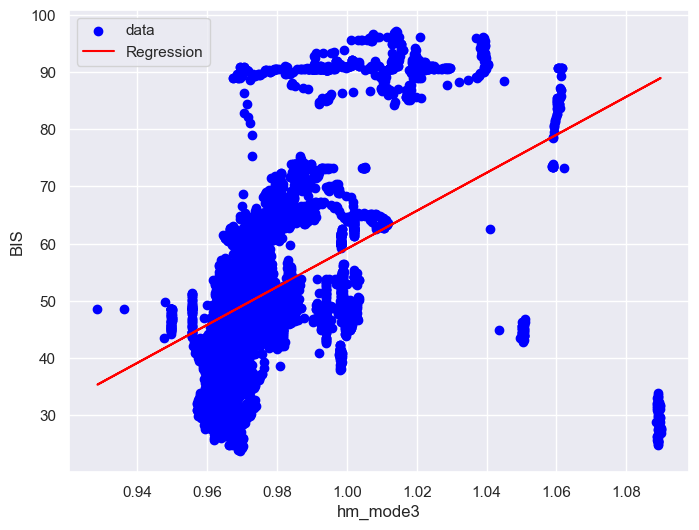

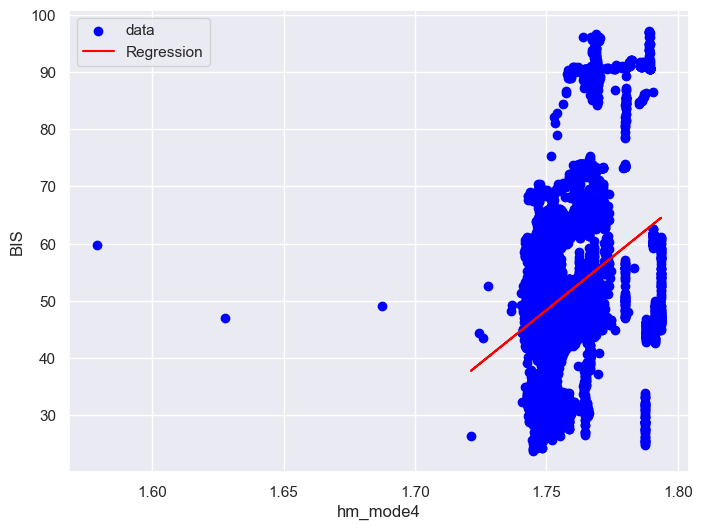

In [86]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

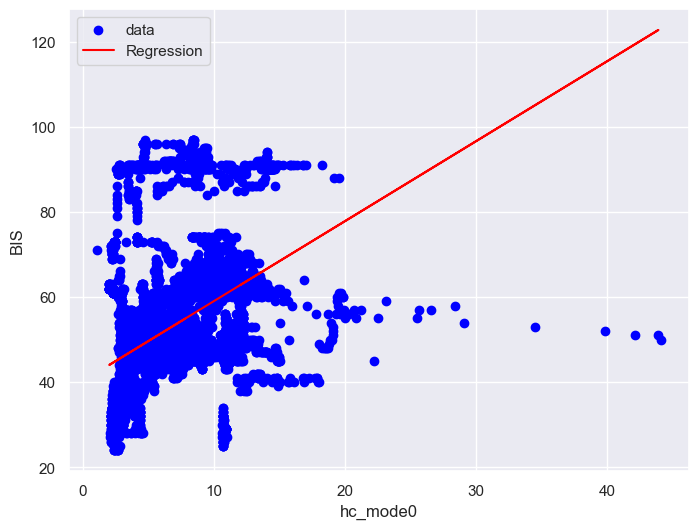

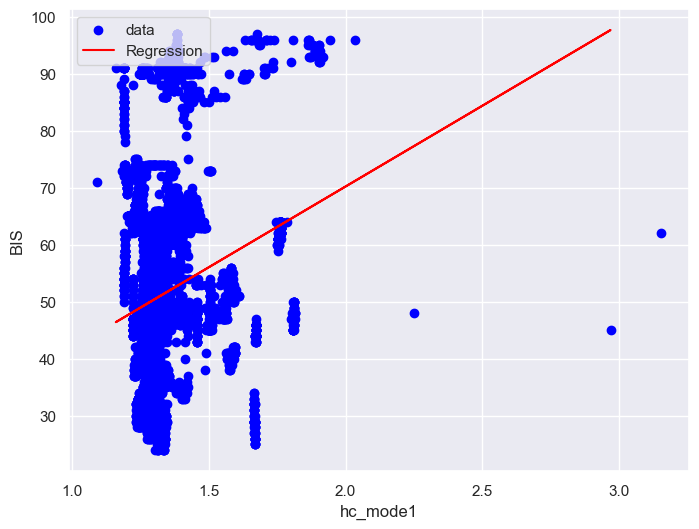

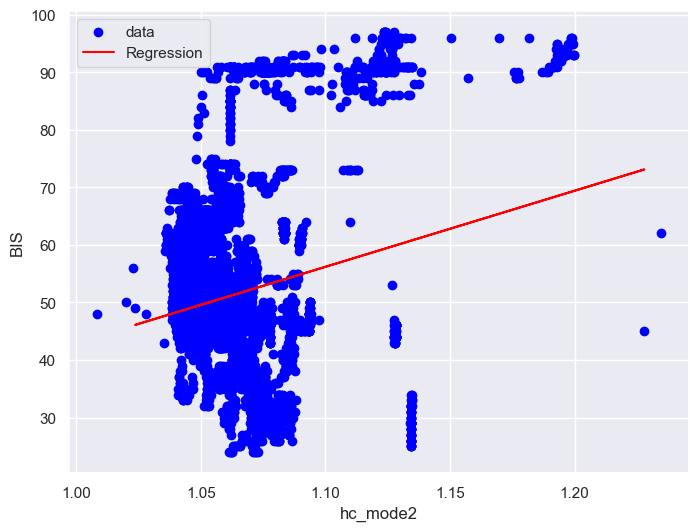

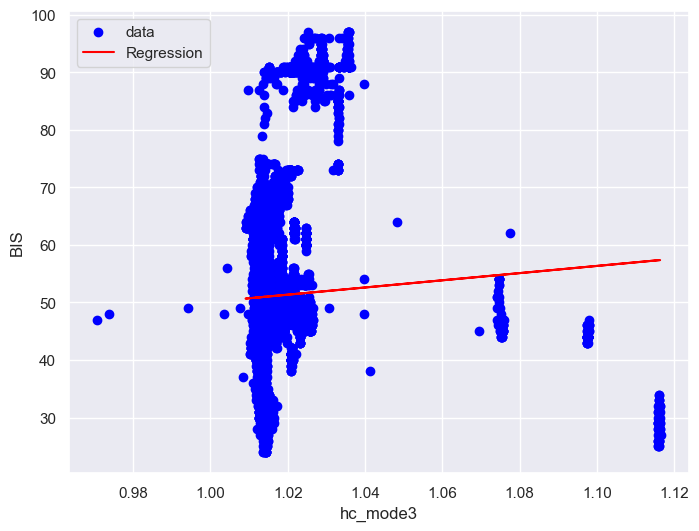

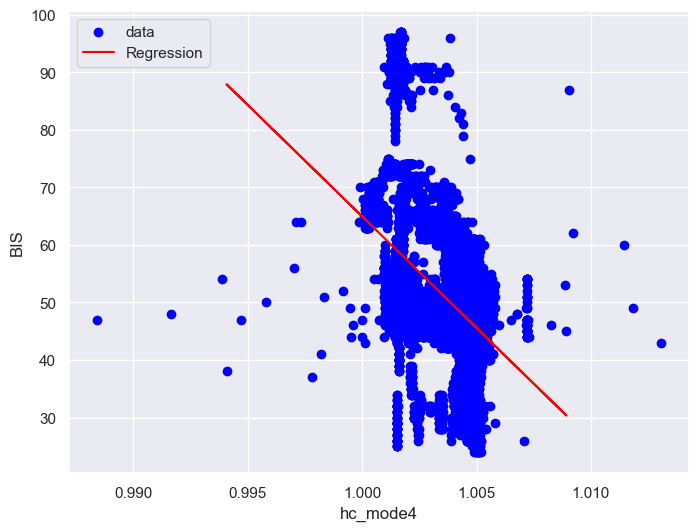

In [87]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

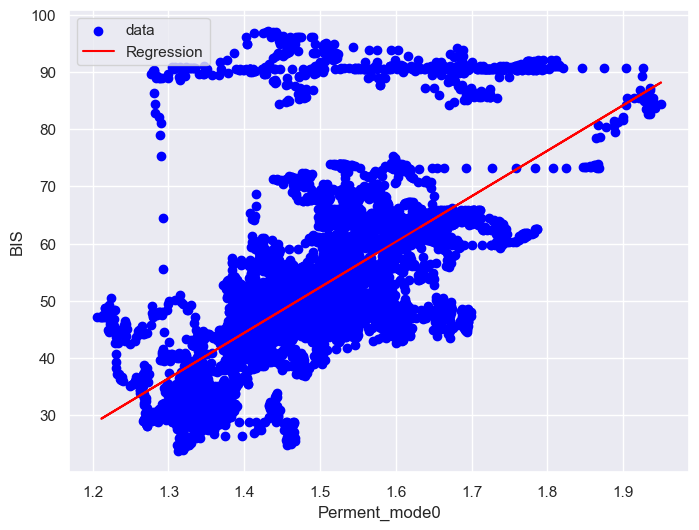

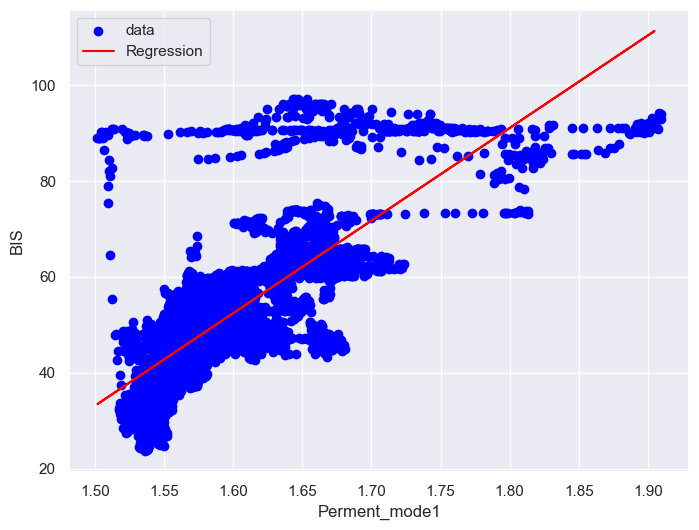

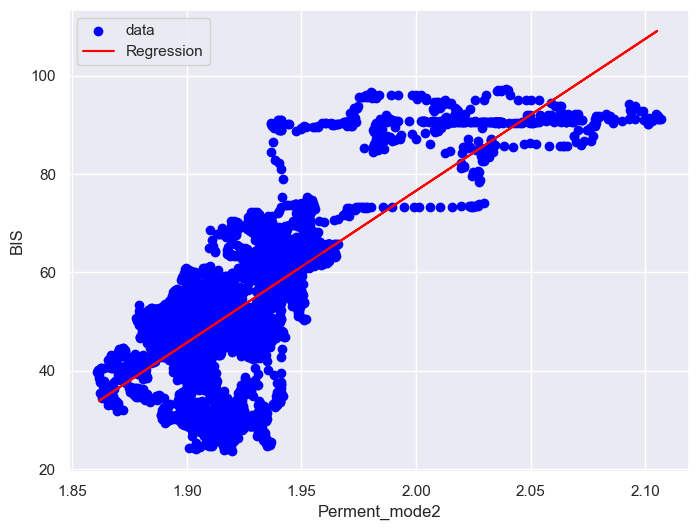

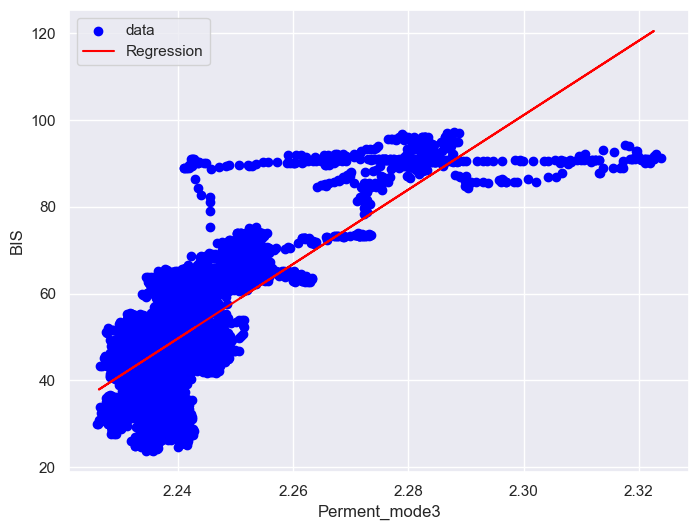

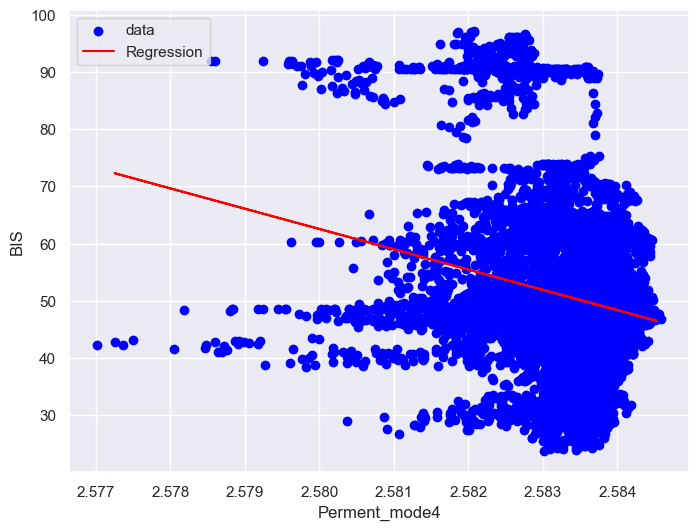

In [88]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

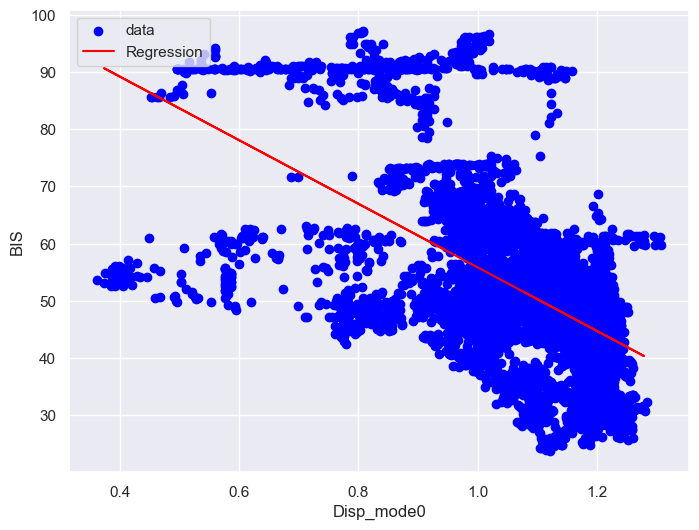

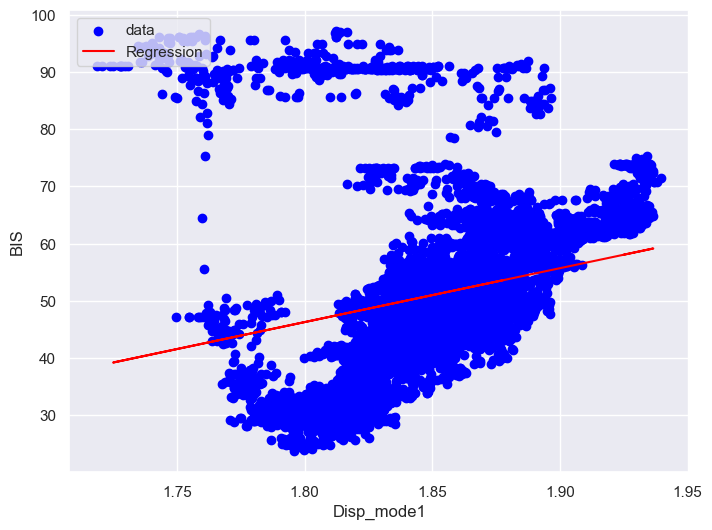

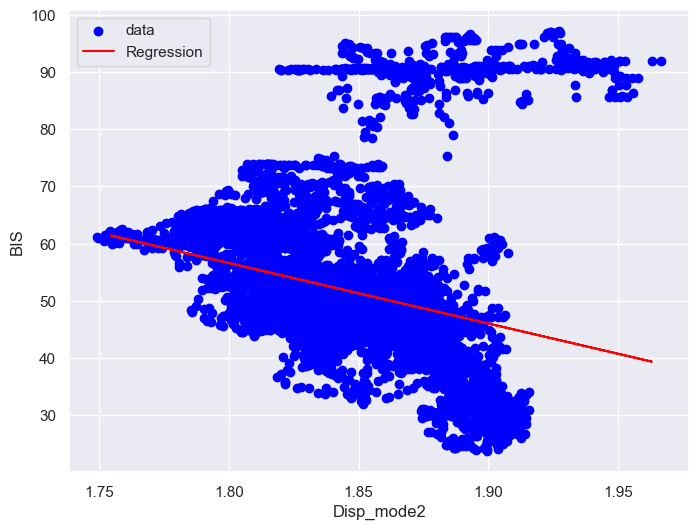

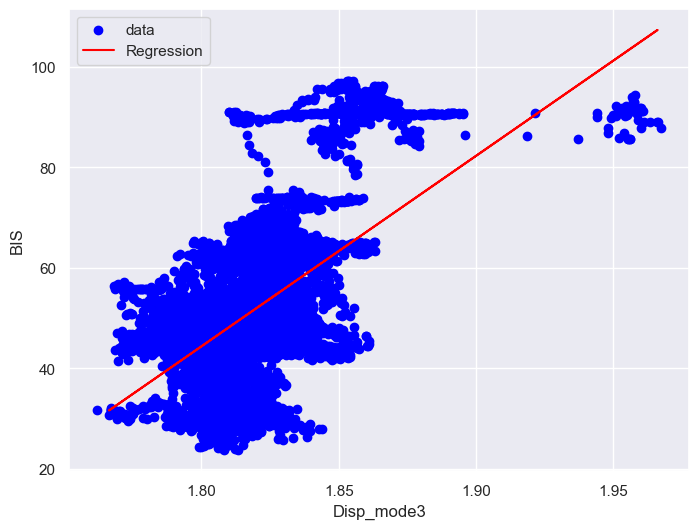

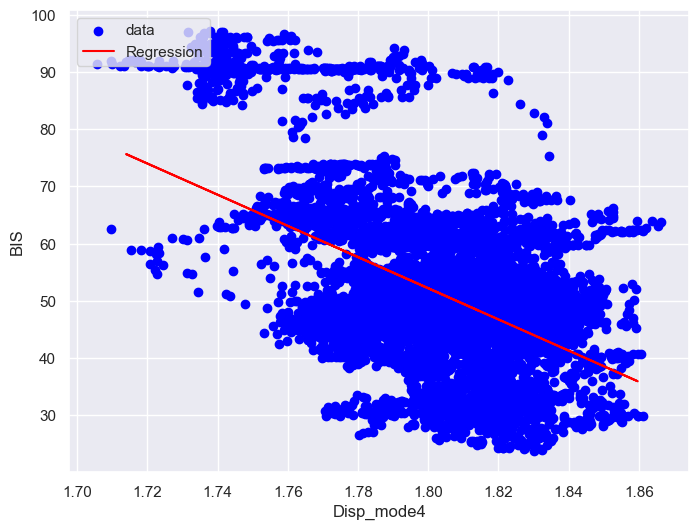

In [89]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})


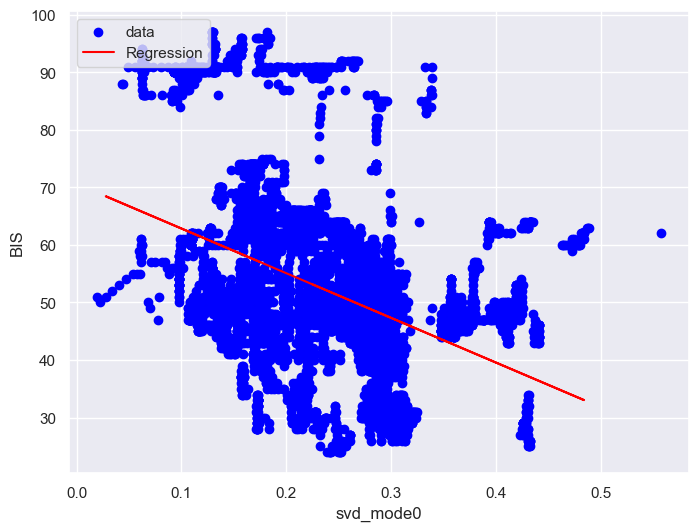

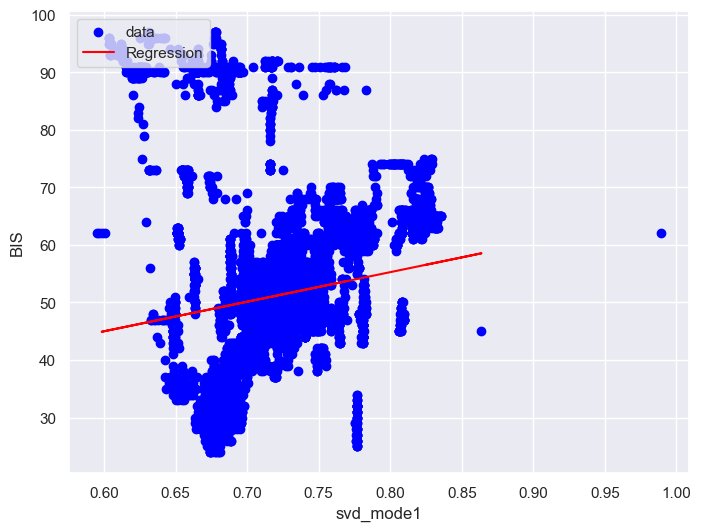

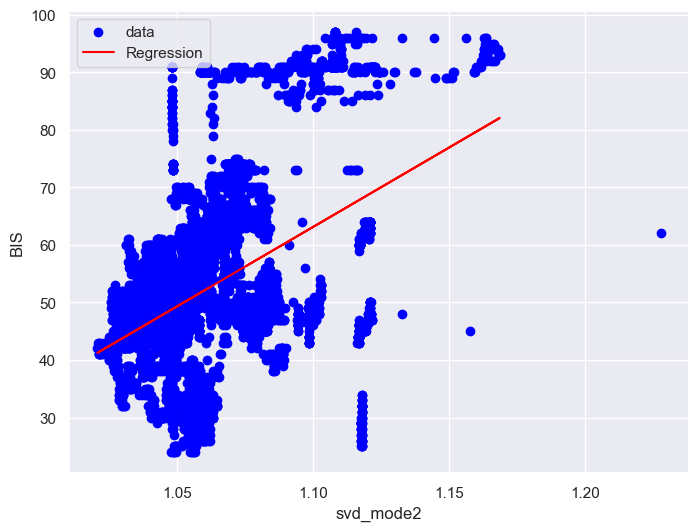

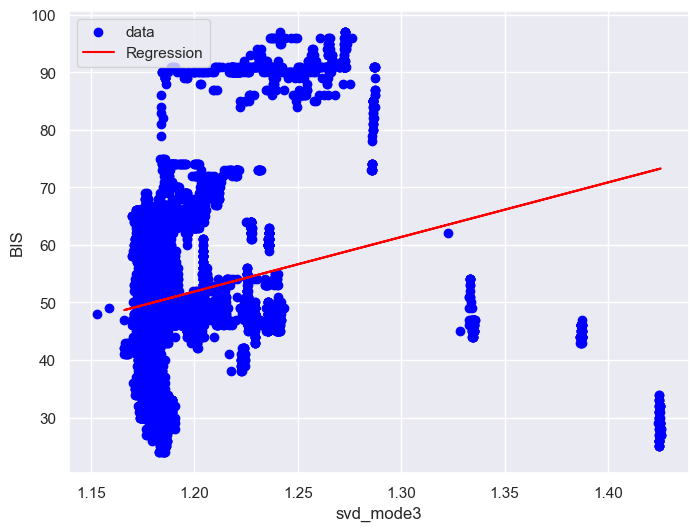

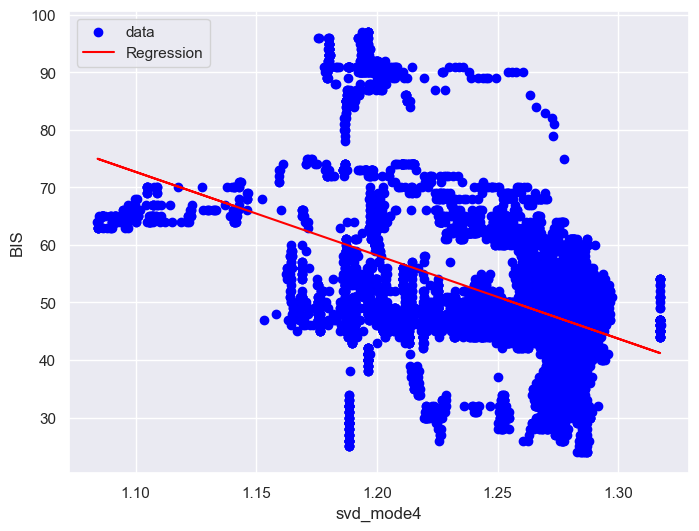

In [90]:
for column in df_svd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_svd, column)

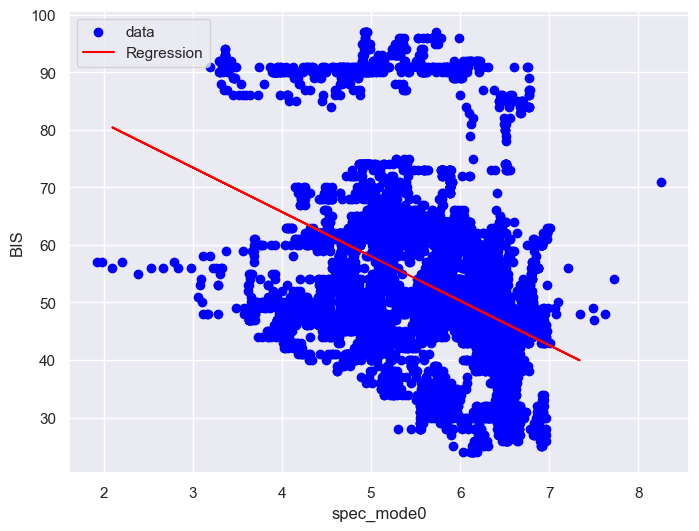

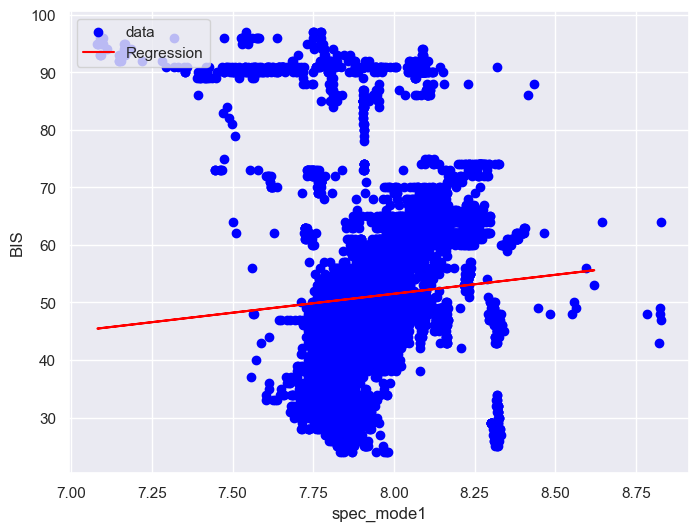

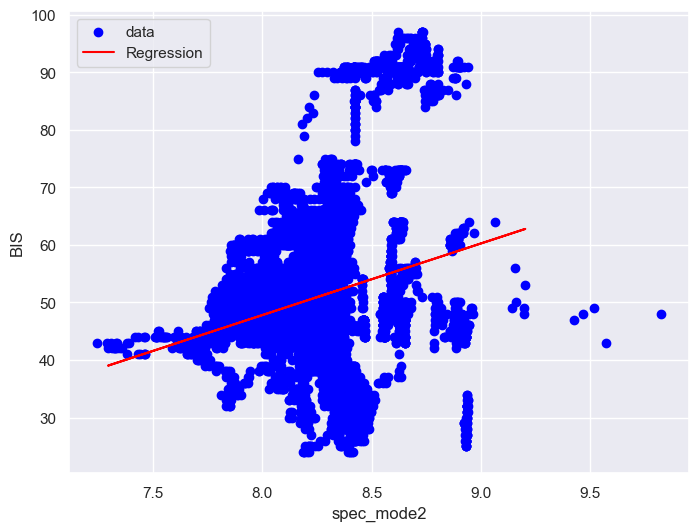

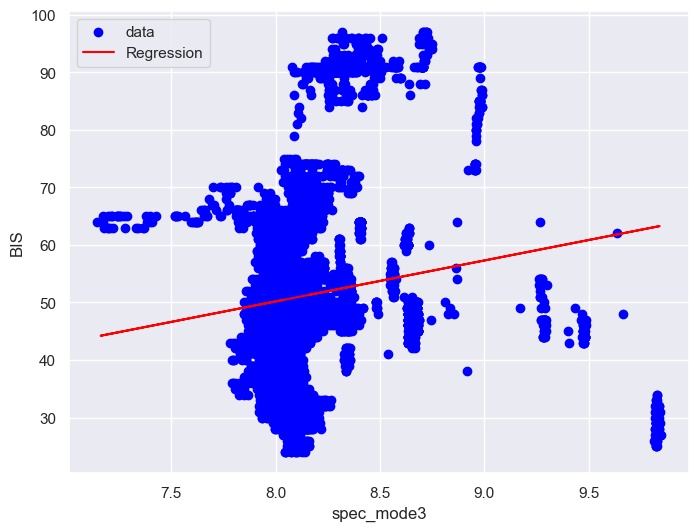

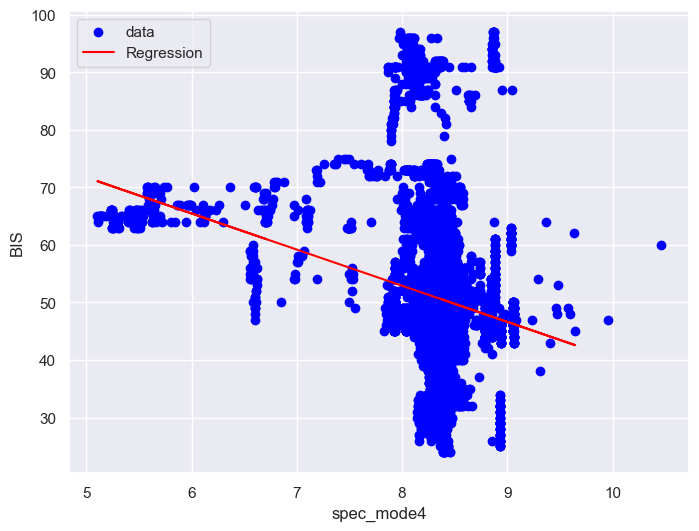

In [91]:
for column in df_spec.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_spec, column)

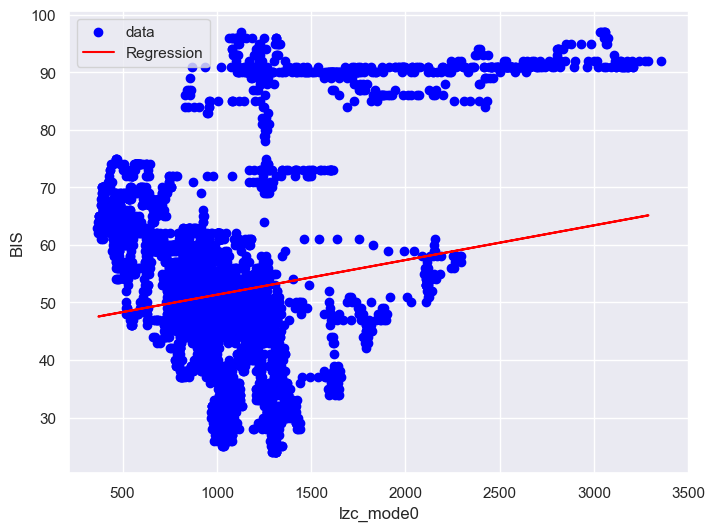

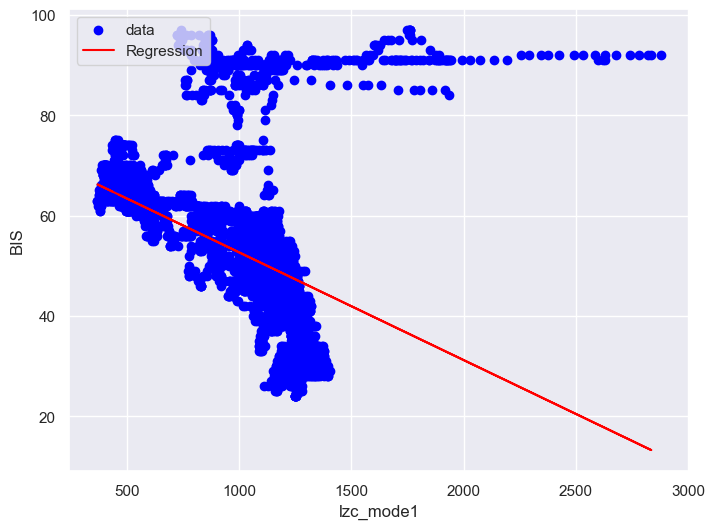

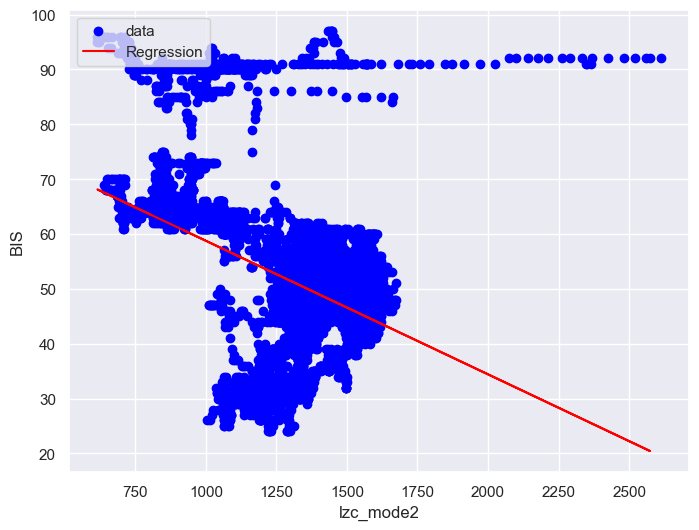

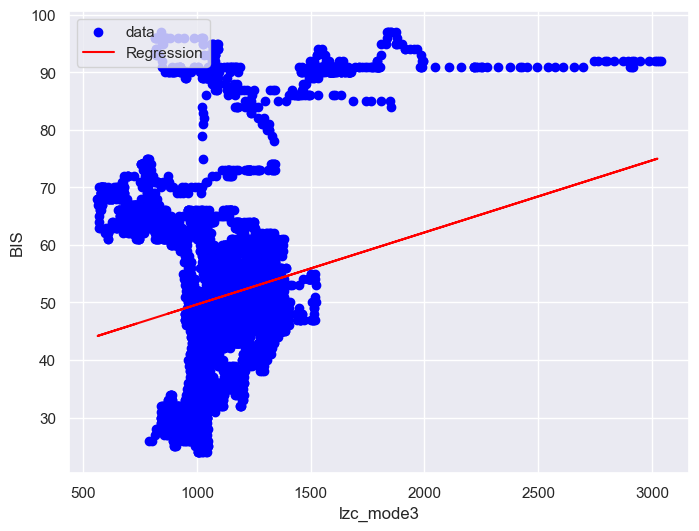

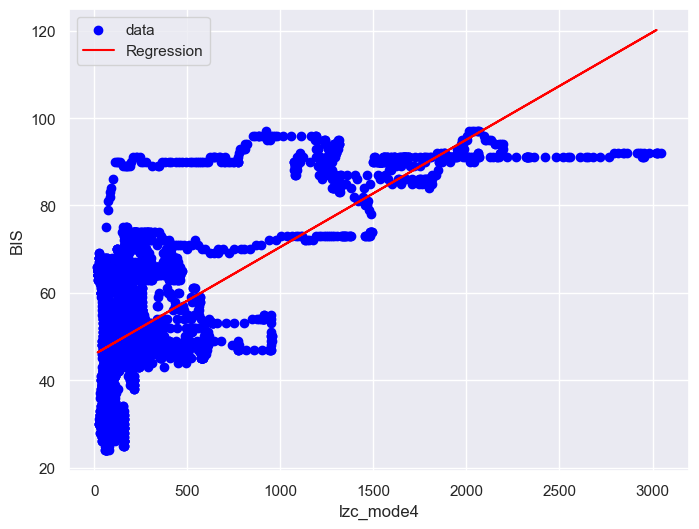

In [92]:
for column in df_lzc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_lzc, column)

In [93]:
# Metrics
total=pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})


In [94]:
sort_total=total.sort_values('Values', ascending=False)
sort_total

Metrics     Values
16  Perment_mode1_r2  59.868992
18  Perment_mode3_r2  58.848140
1       pet_mode1_r2  58.808687
3       pet_mode3_r2  58.154107
2       pet_mode2_r2  58.007556
17  Perment_mode2_r2  57.965102
39      lzc_mode4_r2  45.046700
0       pet_mode0_r2  38.338354
15  Perment_mode0_r2  38.193406
23     Disp_mode3_r2  31.053666
20     Disp_mode0_r2  30.700335
7        hm_mode2_r2  26.502477
24     Disp_mode4_r2  24.162317
8        hm_mode3_r2  21.260084
5        hm_mode0_r2  20.318587
10       hc_mode0_r2  18.770657
36      lzc_mode1_r2  17.528135
30     spec_mode0_r2  17.427618
27      svd_mode2_r2  17.203484
25      svd_mode0_r2  17.175220
29      svd_mode4_r2  17.156094
14       hc_mode4_r2  16.587720
37      lzc_mode2_r2  15.520851
4       pet_mode4_r2  11.878348
9        hm_mode4_r2   8.564524
22     Disp_mode2_r2   6.880964
28      svd_mode3_r2   6.068528
21     Disp_mode1_r2   5.679977
34     spec_mode4_r2   4.311477
11       hc_mode1_r2   4.215240
19  Perment_mode4_r2   3.497332
38      lzc_mode3_r2   3.333338
32     spec_mode2_r2   3.123927
12       hc_mode2_r2   2.667856
26      svd_mode1_r2   2.204431
33     spec_mode3_r2   2.057493
35      lzc_mode0_r2   1.934675
6        hm_mode1_r2   1.841622
13       hc_mode3_r2   0.393609
31     spec_mode1_r2   0.174440